In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 1. LOAD DATA
# =============================

df = pd.read_csv("Spotify_Dataset_V3.csv", delimiter=";")


In [39]:
df.columns

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality',
       'Nationality', 'Continent', 'Points (Total)',
       'Points (Ind for each Artist/Nat)', 'id', 'Song URL'],
      dtype='object')

In [40]:
df.rename(columns={'Title': 'track_name', 'id':'track_id', 'Artists': 'artist'}, inplace=True)

In [ ]:
import pandas as pd

# Ensure date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by track + date
df = df.sort_values(['track_id', 'Date'])

# Compute consecutive days on chart for each track
df['rank_present'] = 1  # every row is a day in Top 200

# Group by track and compute longest chart streak
def longest_streak(x):
    # x is a series of ones by date; streaks = consecutive days
    return x.groupby((x != x.shift()).cumsum()).transform('size').max()

streaks = df.groupby('track_id')['rank_present'].apply(longest_streak)
df_tracks = streaks.reset_index().rename(columns={'rank_present':'longest_run'})

# Create target variable: sustained success = 56 days
df_tracks['sustained_success'] = (df_tracks['longest_run'] >= 56).astype(int)

# df_tracks.head()

dist = df_tracks['sustained_success'].value_counts(normalize=True) * 100
print(dist)


C:\Users\racha\AppData\Local\Temp\ipykernel_36744\2426944120.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


sustained_success
0    74.697085
1    25.302915
Name: proportion, dtype: float64


In [42]:
weeks_per_song = df.groupby('track_id')['Date'].nunique().reset_index()
weeks_per_song.columns = ['track_id', 'total_weeks']

df_tracks_1 = df.merge(weeks_per_song, on='track_id', how='left')

df_tracks_1['sustained_success'] = (df_tracks_1['total_weeks'] >= 8).astype(int)

dist_1 = df_tracks_1['sustained_success'].value_counts(normalize=True) * 100
print(dist_1)

sustained_success
1    97.734594
0     2.265406
Name: proportion, dtype: float64


In [43]:
import pandas as pd

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Rename 'id' → track_id if needed
if 'track_id' not in df.columns:
    df = df.rename(columns={'id': 'track_id'})

# Extract year-week (ISO calendar)
df['year'] = df['Date'].dt.isocalendar().year
df['week'] = df['Date'].dt.isocalendar().week

# Drop duplicate entries per track per week
df_weekly = df.drop_duplicates(subset=['track_id', 'year', 'week'])

# Sort
df_weekly = df_weekly.sort_values(['track_id', 'year', 'week'])

# Each weekly entry counts as one week on chart
df_weekly['week_present'] = 1

# Function: longest run of consecutive weeks
def longest_week_streak(group):
    # Compute whether current week is consecutive from previous
    consecutive = (group['week'].diff() == 1) & (group['year'].diff() == 0)

    # Mark starts of new streaks
    streak_id = (~consecutive).cumsum()

    # For each streak, compute streak length; return max
    return streak_id.value_counts().max()

# Compute longest weekly streak per track
streaks = df_weekly.groupby('track_id').apply(longest_week_streak)
df_tracks = streaks.reset_index().rename(columns={0: 'longest_run_weeks'})

# Create target variable: sustained success = ≥ 8 weeks
df_tracks['sustained_success'] = (df_tracks['longest_run_weeks'] >= 8).astype(int)

# Class distribution
dist = df_tracks['sustained_success'].value_counts(normalize=True) * 100
print(dist)


sustained_success
0    77.295055
1    22.704945
Name: proportion, dtype: float64


In [50]:
import pandas as pd

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Rename 'id' → track_id if needed
if 'track_id' not in df.columns:
    df = df.rename(columns={'id': 'track_id'})

# Convert dates to "week start" (Monday of that ISO week)
df['week_start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='D')

# Convert to absolute week index (integer)
df['week_index'] = (df['week_start'] - df['week_start'].min()) // pd.Timedelta(days=7)
df['week_index'] = df['week_index'].astype(int)

# Drop duplicates per track per week
df_weekly = df.drop_duplicates(subset=['track_id', 'week_index'])

# Sort
df_weekly = df_weekly.sort_values(['track_id', 'week_index'])

# Consecutive-week streak calculation
def longest_week_streak(group):
    # Consecutive if the difference in week_index is exactly 1
    consecutive = (group['week_index'].diff() == 1)
    streak_id = (~consecutive).cumsum()
    return streak_id.value_counts().max()

# Compute longest streak per track
streaks = df_weekly.groupby('track_id').apply(longest_week_streak)
df_tracks = streaks.reset_index().rename(columns={0: 'longest_run_weeks'})

# Target: sustained success = 8 consecutive weeks
df_tracks['sustained_success'] = (df_tracks['longest_run_weeks'] >= 8).astype(int)

# Class distribution
dist = df_tracks['sustained_success'].value_counts(normalize=True) * 100
print(dist)


sustained_success
0    74.828076
1    25.171924
Name: proportion, dtype: float64


In [45]:
df = df.merge(df_tracks[['track_id', 'sustained_success']], on='track_id', how='left')


In [51]:
audio_features = ["Danceability", "Loudness", "Valence", "Energy", "Acousticness"]

corr_results = df[audio_features + ["sustained_success"]].corr()['sustained_success'][audio_features]
print(corr_results)


Danceability    0.052397
Loudness        0.080159
Valence         0.022310
Energy          0.037792
Acousticness   -0.031104
Name: sustained_success, dtype: float64


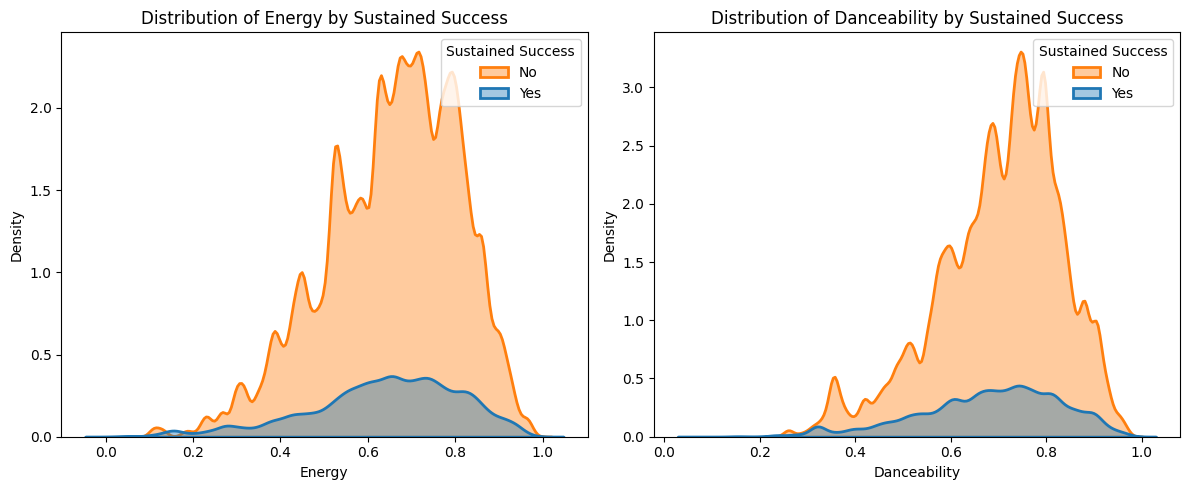

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# --- Left plot: Energy ---
plt.subplot(1,2,1)
sns.kdeplot(
    data=df, 
    x="Energy", 
    hue="sustained_success",
    fill=True, alpha=0.4, linewidth=2
)
plt.title("Distribution of Energy by Sustained Success")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend(title="Sustained Success", labels=["No", "Yes"])

# --- Right plot: Danceability ---
plt.subplot(1,2,2)
sns.kdeplot(
    data=df, 
    x="Danceability", 
    hue="sustained_success",
    fill=True, alpha=0.4, linewidth=2
)
plt.title("Distribution of Danceability by Sustained Success")
plt.xlabel("Danceability")
plt.ylabel("Density")
plt.legend(title="Sustained Success", labels=["No", "Yes"])

plt.tight_layout()
plt.savefig("sustained_success_distributions.png", dpi=300, bbox_inches='tight')
plt.savefig("sustained_success_distributions.svg", format = 'svg', dpi=300, bbox_inches='tight')
plt.show()


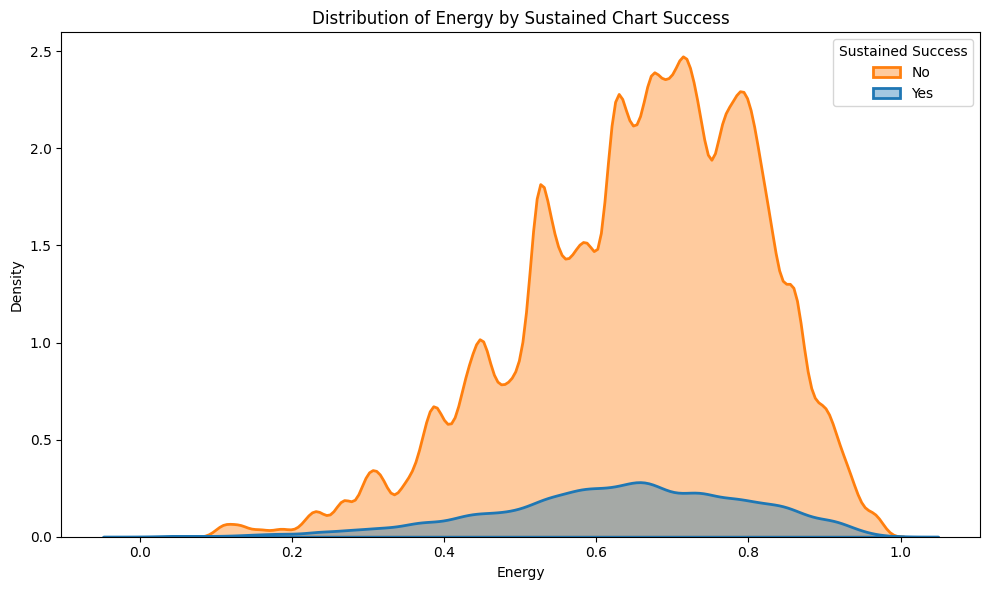

In [29]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df, 
    x="Energy", 
    hue="sustained_success",
    fill=True, alpha=0.4, linewidth=2
)

plt.title("Distribution of Energy by Sustained Chart Success")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend(title="Sustained Success", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


In [14]:

# Ensure columns exist
required_cols = ["track_name", "artist", "week", "valence", "loudness", "danceability", "energy"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")


In [16]:

# =============================
# 2. COMPUTE LONGEST WEEKLY RUN FOR EACH SONG
# =============================

def longest_week_streak(weeks):
    """
    Compute the longest consecutive-week streak from a sorted list of week numbers.
    """
    weeks = sorted(weeks)
    longest = 1
    current = 1
    
    for i in range(1, len(weeks)):
        if weeks[i] == weeks[i-1] + 1:
            current += 1
            longest = max(longest, current)
        else:
            current = 1
    return longest

# Apply per track
song_streaks = (
    df.groupby(["track_name", "artist"])["week"]
      .apply(lambda x: longest_week_streak(x.unique()))
      .reset_index(name="longest_week_run")
)

song_streaks.head()


,track_name,artist,longest_week_run
0,'98 Braves,Morgan Wallen,2
1,!,Trippie Redd,1
2,#PROUDCATOWNERREMIX,"XXXTENTACION, Rico Nasty",1
3,$$$,XXXTENTACION,3
4,$€ Freestyle,Sfera Ebbasta,1


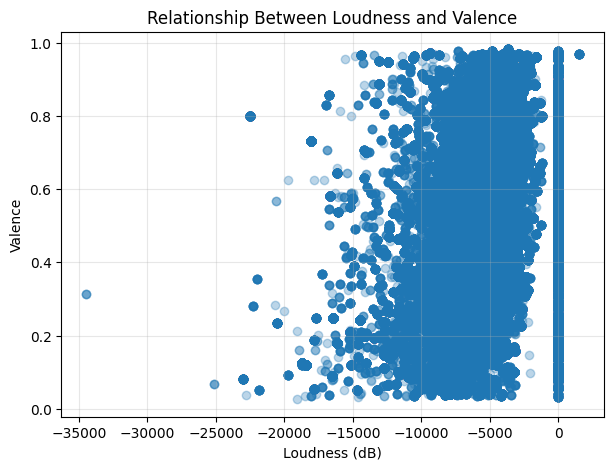

In [17]:

# =============================
# 3. PLOT: VALENCE VS LOUDNESS (Most Impactful Graph)
# =============================

plt.figure(figsize=(7,5))
plt.scatter(df["loudness"], df["valence"], alpha=0.3)
plt.xlabel("Loudness (dB)")
plt.ylabel("Valence")
plt.title("Relationship Between Loudness and Valence")
plt.grid(alpha=0.3)
plt.show()


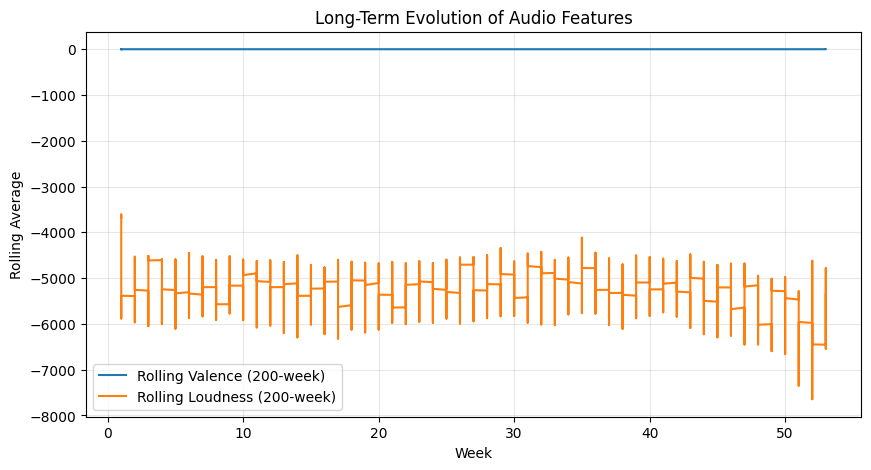

In [18]:

# =============================
# 4. PLOT: ROLLING AUDIO FEATURE EVOLUTION
# =============================

df_sorted = df.sort_values("week")
df_sorted["rolling_valence"] = df_sorted["valence"].rolling(200, min_periods=50).mean()
df_sorted["rolling_loudness"] = df_sorted["loudness"].rolling(200, min_periods=50).mean()

plt.figure(figsize=(10,5))
plt.plot(df_sorted["week"], df_sorted["rolling_valence"], label="Rolling Valence (200-week)")
plt.plot(df_sorted["week"], df_sorted["rolling_loudness"], label="Rolling Loudness (200-week)")
plt.xlabel("Week")
plt.ylabel("Rolling Average")
plt.title("Long-Term Evolution of Audio Features")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


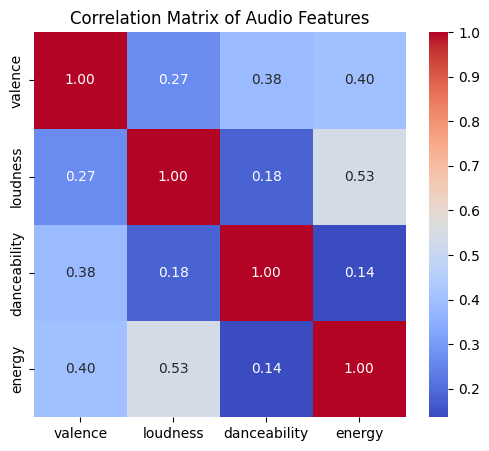

In [19]:

# =============================
# 5. OPTIONAL: FEATURE CORRELATION HEATMAP
# =============================

import seaborn as sns

audio_cols = ["valence", "loudness", "danceability", "energy"]
corr = df[audio_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Audio Features")
plt.show()
